# Image Deblurring - June Exam

### Dataset creation - DO NOT MODIFY

In [6]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, Dense, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

In [7]:
(x_train_blured_og, x_train_og), (x_test_blured, x_test) = getDataset()

In [8]:
x_train_og.shape

(50000, 32, 32, 3)

In [9]:
# Split the training set into training and validation.
TRAIN_SIZE = 40000

x_train_blured = x_train_blured_og[:TRAIN_SIZE]
x_train = x_train_og[:TRAIN_SIZE]

x_val_blured = x_train_blured_og[TRAIN_SIZE:]
x_val = x_train_og[TRAIN_SIZE:]

print(f"Train size: {x_train_blured.shape}. Test size: {x_val_blured.shape}")

Train size: (40000, 32, 32, 3). Test size: (10000, 32, 32, 3)


In [14]:
#encode
input = Input(shape=(32, 32, 3))

x = Conv2D(64, (3, 3), strides = 1, padding = 'same', input_shape = (32, 32, 3)) (input)

x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (x)

x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (x)

#latent
x = Conv2D(8, (2, 2), strides = 1, padding = 'same') (x)
x = Dense(16, activation='relu')(x)
x = Conv2D(16, (2, 2), strides = 1, padding = 'same') (x)
x = Dense(16, activation='relu')(x)
x = Conv2D(8, (2, 2), strides = 1, padding = 'same') (x)
#decode

x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same') (x)
output = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)

model = Model(inputs=input,outputs=output)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 conv2d_25 (Conv2D)          (None, 32, 32, 16)        4112      
                                                                 
 conv2d_26 (Conv2D)          (None, 32, 32, 16)        1040      
                                                                 
 conv2d_27 (Conv2D)          (None, 32, 32, 8)         520       
                                                                 
 dense_8 (Dense)             (None, 32, 32, 16)        144       
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 16)        1040

In [15]:
adam_optimizer = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss = 'mse', optimizer = adam_optimizer,metrics=["mae", "acc"])
hist = model.fit(x_train_blured.reshape(-1, 32, 32, 3), 
          x_train.reshape(-1, 32, 32, 3), 
          epochs = 10, 
          batch_size = 200, 
          
          validation_data = (x_val_blured.reshape(-1, 32, 32, 3), x_val.reshape(-1, 32, 32, 3)))

Epoch 1/10
200/200 [==============================] - 10s 45ms/step - loss: 0.0308 - mae: 0.1328 - acc: 0.5323 - val_loss: 0.0125 - val_mae: 0.0817 - val_acc: 0.6289
Epoch 2/10
200/200 [==============================] - 9s 45ms/step - loss: 0.0107 - mae: 0.0755 - acc: 0.6373 - val_loss: 0.0093 - val_mae: 0.0705 - val_acc: 0.6498
Epoch 3/10
200/200 [==============================] - 9s 45ms/step - loss: 0.0087 - mae: 0.0685 - acc: 0.6479 - val_loss: 0.0081 - val_mae: 0.0660 - val_acc: 0.6503
Epoch 4/10
200/200 [==============================] - 9s 46ms/step - loss: 0.0078 - mae: 0.0647 - acc: 0.6559 - val_loss: 0.0074 - val_mae: 0.0630 - val_acc: 0.6597
Epoch 5/10
200/200 [==============================] - 9s 43ms/step - loss: 0.0071 - mae: 0.0619 - acc: 0.6602 - val_loss: 0.0068 - val_mae: 0.0608 - val_acc: 0.6540
Epoch 6/10
200/200 [==============================] - 9s 46ms/step - loss: 0.0067 - mae: 0.0602 - acc: 0.6642 - val_loss: 0.0065 - val_mae: 0.0592 - val_acc: 0.6606
Epoch 7/1

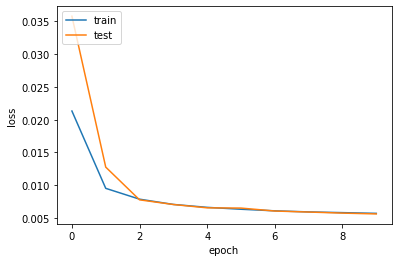

In [55]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(hist,['loss','val_loss'])

In [ ]:
predictions = model.predict(x_test_blured)

In [ ]:
predictions.shape

In [ ]:
from sklearn.metrics import mean_squared_error

nsamples, nx, ny, nc = x_test.shape
x_true = x_test.reshape((nsamples,nx*ny*nc))

nsamples, nx, ny, nc = predictions.shape
x_pred = predictions.reshape((nsamples,nx*ny*nc))

mean_squared_error(x_true, x_pred)

In [ ]:
#utility function to pick samples to be tested

def get_samples(arr, n):
    temp = random.sample(range(len(arr)), n)
    result = arr[temp]
    return result, temp

num = 3
org, temp = get_samples(x_test, num)
blur = x_test_blured[temp]
preds = model.predict(blur.reshape(-1, 32, 32, 3))
#plotting results
plt.figure(figsize = (20, 20))
print('Original Images')
for i in range(num):
    plt.subplot(1, num, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(org[i])
plt.show()
plt.figure(figsize = (20, 20))
print('Blurred Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(blur[i])
plt.show()
plt.figure(figsize = (20, 20))
print('Predicted Images')
for i in range(num):
    plt.subplot(1, num, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(preds[i])
plt.show()

SOLUZIONE 2

In [50]:
from keras.layers import Input
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.core import Dense, Flatten
from keras.layers import BatchNormalization
from keras.models import Model


from keras.layers import Input, Activation, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.core import Lambda
from keras.models import Model

ndf = 64
ngf = 64
n_blocks_gen = 9
output_nc = 3
input_shape_discriminator = (32, 32, output_nc)

inputs = Input(shape=(32, 32, 3))

x = Conv2D(filters=ngf, kernel_size=(7,7), padding='valid')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Increase filter number
n_downsampling = 2
for i in range(n_downsampling):
    mult = 2**i
    x = Conv2D(filters=ngf*mult*2, kernel_size=(3,3), strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

# Apply 9 ResNet blocks
mult = 2**n_downsampling
for i in range(n_blocks_gen):
    pass
    # x = res_block(x, ngf*mult, use_dropout=True)

# Decrease filter number to 3 (RGB)
for i in range(n_downsampling):
    mult = 2**(n_downsampling - i)
    x = Conv2DTranspose(filters=int(ngf * mult / 2), kernel_size=(2, 2), strides=3-i, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

x = Conv2D(filters=32, kernel_size=(7,7), padding='valid')(x)
x = Conv2D(filters=64, kernel_size=(5,5), padding='valid')(x)
x = Conv2D(filters=output_nc, kernel_size=(1,1), padding='valid')(x)

x = Activation('tanh')(x)

# Add direct connection from input to output and recenter to [-1, 1]
# outputs = Add()([x, inputs])
# outputs = Lambda(lambda z: z/2)(x)

x = Conv2D(8, (2, 2), strides = 1, padding = 'same') (x)
#decode
x = Conv2DTranspose(16, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(32, (2, 2), strides = 1, padding = 'same') (x)
x = Conv2DTranspose(64, (2, 2), strides = 1, padding = 'same') (x)
outputs = Conv2DTranspose(3, (1, 1), strides = 1, activation = 'sigmoid', padding = 'same') (x)
model = Model(inputs=inputs, outputs=outputs, name='Generator')
model.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_118 (Conv2D)         (None, 26, 26, 64)        9472      
                                                                 
 batch_normalization_115 (Ba  (None, 26, 26, 64)       256       
 tchNormalization)                                               
                                                                 
 activation_138 (Activation)  (None, 26, 26, 64)       0         
                                                                 
 conv2d_119 (Conv2D)         (None, 13, 13, 128)       73856     
                                                                 
 batch_normalization_116 (Ba  (None, 13, 13, 128)      512       
 tchNormalization)                                       

In [51]:
# adam_optimizer = Adam(learning_rate=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(loss = 'mse', optimizer = 'adam')
hist = model.fit(x_train_blured.reshape(-1, 32, 32, 3), 
          x_train.reshape(-1, 32, 32, 3), 
          epochs = 10, 
          batch_size = 200, 
          validation_data = (x_val_blured.reshape(-1, 32, 32, 3), x_val.reshape(-1, 32, 32, 3)))

Epoch 1/10
200/200 [==============================] - 25s 119ms/step - loss: 0.0308 - val_loss: 0.0400
Epoch 2/10
200/200 [==============================] - 24s 121ms/step - loss: 0.0185 - val_loss: 0.0187
Epoch 3/10
200/200 [==============================] - 24s 122ms/step - loss: 0.0158 - val_loss: 0.0152
Epoch 4/10
200/200 [==============================] - 23s 116ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 5/10
200/200 [==============================] - 23s 117ms/step - loss: 0.0140 - val_loss: 0.0142
Epoch 6/10
200/200 [==============================] - 24s 118ms/step - loss: 0.0135 - val_loss: 0.0132
Epoch 7/10
200/200 [==============================] - 23s 117ms/step - loss: 0.0132 - val_loss: 0.0139
Epoch 8/10
200/200 [==============================] - 23s 117ms/step - loss: 0.0129 - val_loss: 0.0131
Epoch 9/10
200/200 [==============================] - 24s 122ms/step - loss: 0.0126 - val_loss: 0.0135
Epoch 10/10
200/200 [==============================] - 24s 118ms/step - l

In [ ]:
def plot_history(model_history,keys):
    m,val_m = keys
    plt.plot(model_history.history[m])
    plt.plot(model_history.history[val_m])
    plt.ylabel(m)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(hist,['loss','val_loss'])